v1


2015 Regression Statistics:
Slope: -0.1700
Intercept: 10.7649
R-squared: 0.6136
95% CI for Slope: (-0.2799, -0.0600)

2020 Regression Statistics:
Slope: -0.1850
Intercept: 10.8326
R-squared: 0.4932
95% CI for Slope: (-0.3379, -0.0321)



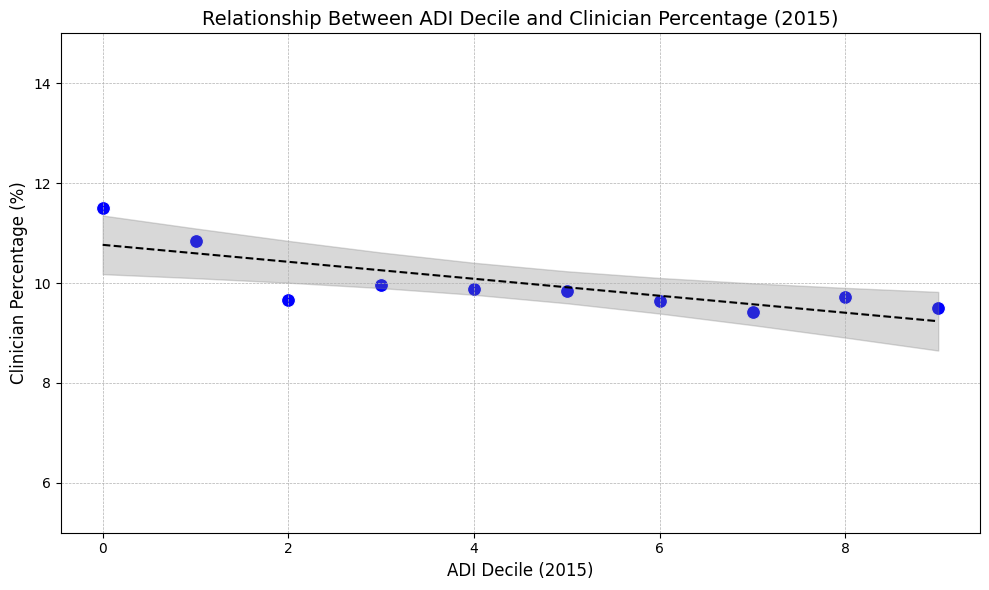

Relationship Between ADI Decile and Clinician Percentage (2015) Regression Statistics:
Slope: -0.1700
Intercept: 10.7649
R-squared: 0.6136
95% CI for Slope: (-0.2799, -0.0600)
95% CI for Intercept: (10.1779, 11.3519)



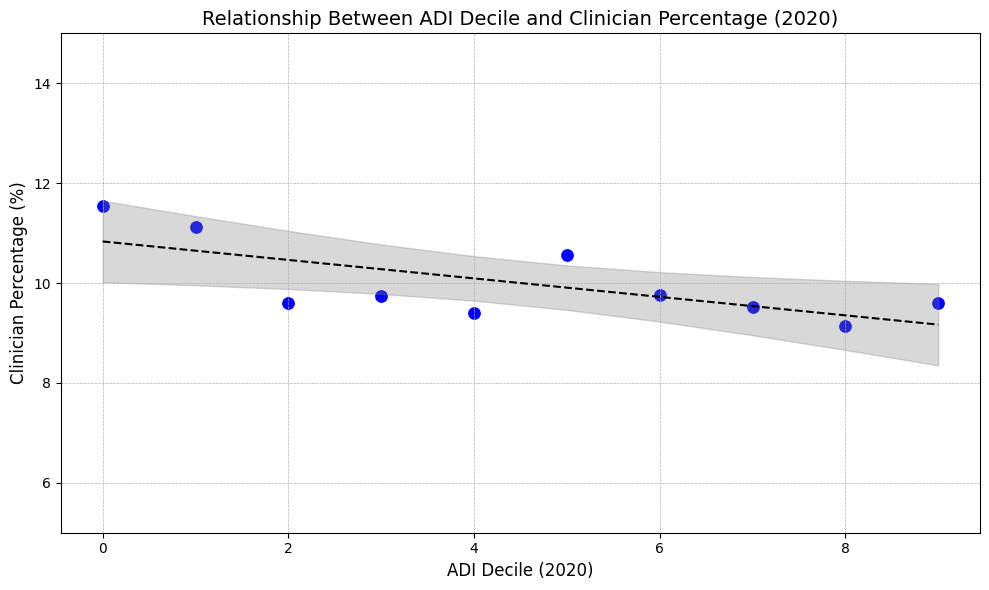

Relationship Between ADI Decile and Clinician Percentage (2020) Regression Statistics:
Slope: -0.1850
Intercept: 10.8326
R-squared: 0.4932
95% CI for Slope: (-0.3379, -0.0321)
95% CI for Intercept: (10.0162, 11.6489)



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Load the updated dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Function to filter doctors based on top 20 flag
def filter_doctors(data, top20_flag):
    return data[data['top20_institution'] == top20_flag]

# Function to perform aggregation and prepare ADI decile data
def prepare_aggregated_data(data):
    # Assign ADI Scores to Clinicians and aggregate data by ZIP Code and State
    adi_data = data[['ZIP Code', 'Grd_yr', 'State', 'Avg_ADI_NATRANK_2015', 'Avg_ADI_NATRANK_2020', 'top20_institution', 'pri_spec_grouped']]
    adi_data['clinician_count'] = 1

    # Aggregate data by ZIP Code, Year, State, and ADI
    adi_aggregated = adi_data.groupby(['ZIP Code', 'Grd_yr', 'State']).agg(
        total_clinicians=('clinician_count', 'sum'),
        Avg_ADI_2015=('Avg_ADI_NATRANK_2015', 'mean'),
        Avg_ADI_2020=('Avg_ADI_NATRANK_2020', 'mean')
    ).reset_index()

    # Group ADI Scores into Deciles
    adi_aggregated['ADI_decile_2015'] = pd.qcut(adi_aggregated['Avg_ADI_2015'], 10, labels=False)
    adi_aggregated['ADI_decile_2020'] = pd.qcut(adi_aggregated['Avg_ADI_2020'], 10, labels=False)

    return adi_aggregated

# Function to calculate clinician percentages by decile
def calculate_clinician_percentage(data, year):
    if year == 2015:
        adi_decile_density = data.groupby('ADI_decile_2015').agg(
            clinician_count=('total_clinicians', 'sum')
        ).reset_index()

        total_clinicians = adi_decile_density['clinician_count'].sum()
        adi_decile_density['clinician_percentage'] = (adi_decile_density['clinician_count'] / total_clinicians) * 100
        adi_decile_density.rename(columns={'ADI_decile_2015': 'ADI_decile'}, inplace=True)

    elif year == 2020:
        adi_decile_density = data.groupby('ADI_decile_2020').agg(
            clinician_count=('total_clinicians', 'sum')
        ).reset_index()

        total_clinicians = adi_decile_density['clinician_count'].sum()
        adi_decile_density['clinician_percentage'] = (adi_decile_density['clinician_count'] / total_clinicians) * 100
        adi_decile_density.rename(columns={'ADI_decile_2020': 'ADI_decile'}, inplace=True)

    return adi_decile_density

# Function to calculate regression statistics
def calculate_regression_stats(data, x_column, y_column):
    # Fit the regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()

    # Extract regression statistics
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    return slope, intercept, r_squared, conf_int

# Function to plot scatter plot with regression line and print regression stats (without legend)
def plot_scatter_with_regression_and_stats(data, x_column, y_column, title, x_label, y_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=x_column, y=y_column, data=data, s=100, color='blue')

    # Fit a regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()
    y_pred = model.predict(X)

    # Plot regression line
    plt.plot(data[x_column], y_pred, color='black', linestyle='--')

    # Plot confidence interval
    pred = model.get_prediction(X)
    pred_ci = pred.conf_int()
    plt.fill_between(data[x_column], pred_ci[:, 0], pred_ci[:, 1], color='gray', alpha=0.3)

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.ylim(5, 15)

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

    # Print regression stats
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    print(f"{title} Regression Statistics:")
    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"95% CI for Slope: ({conf_int.iloc[1, 0]:.4f}, {conf_int.iloc[1, 1]:.4f})")
    print(f"95% CI for Intercept: ({conf_int.iloc[0, 0]:.4f}, {conf_int.iloc[0, 1]:.4f})\n")

# Main function to run the analysis
def run_analysis(top20_flag):
    # Step 1: Filter doctors based on top 20 flag (1 for top 20 institutions, 0 for others)
    medical_data_filtered = filter_doctors(medical_data, top20_flag)

    # Step 2: Prepare aggregated data
    adi_aggregated = prepare_aggregated_data(medical_data_filtered)

    # Step 3: Calculate clinician percentage for 2015 and 2020
    adi_decile_density_2015 = calculate_clinician_percentage(adi_aggregated, 2015)
    adi_decile_density_2020 = calculate_clinician_percentage(adi_aggregated, 2020)

    # Step 4: Calculate regression stats for 2015 and 2020
    slope_2015, intercept_2015, r_squared_2015, conf_int_2015 = calculate_regression_stats(adi_decile_density_2015, 'ADI_decile', 'clinician_percentage')
    slope_2020, intercept_2020, r_squared_2020, conf_int_2020 = calculate_regression_stats(adi_decile_density_2020, 'ADI_decile', 'clinician_percentage')

    # Print regression statistics for 2015
    print(f"2015 Regression Statistics:")
    print(f"Slope: {slope_2015:.4f}")
    print(f"Intercept: {intercept_2015:.4f}")
    print(f"R-squared: {r_squared_2015:.4f}")
    print(f"95% CI for Slope: ({conf_int_2015.iloc[1, 0]:.4f}, {conf_int_2015.iloc[1, 1]:.4f})\n")

    # Print regression statistics for 2020
    print(f"2020 Regression Statistics:")
    print(f"Slope: {slope_2020:.4f}")
    print(f"Intercept: {intercept_2020:.4f}")
    print(f"R-squared: {r_squared_2020:.4f}")
    print(f"95% CI for Slope: ({conf_int_2020.iloc[1, 0]:.4f}, {conf_int_2020.iloc[1, 1]:.4f})\n")

    # Step 5: Plot scatter plot with regression line for 2015
    plot_scatter_with_regression_and_stats(
        adi_decile_density_2015,
        'ADI_decile',
        'clinician_percentage',
        'Relationship Between ADI Decile and Clinician Percentage (2015)',
        'ADI Decile (2015)',
        'Clinician Percentage (%)'
    )

    # Step 6: Plot scatter plot with regression line for 2020
    plot_scatter_with_regression_and_stats(
        adi_decile_density_2020,
        'ADI_decile',
        'clinician_percentage',
        'Relationship Between ADI Decile and Clinician Percentage (2020)',
        'ADI Decile (2020)',
        'Clinician Percentage (%)'
    )

# Example of running the analysis for doctors from top 20 institutions
run_analysis(top20_flag=0)

# Example of running the analysis for doctors outside top 20


2015 Regression Statistics:
Slope: -0.5341
Intercept: 12.4034
R-squared: 0.4050
95% CI for Slope: (-1.0619, -0.0063)

2020 Regression Statistics:
Slope: -0.0408
Intercept: 10.1835
R-squared: 0.0048
95% CI for Slope: (-0.5205, 0.4389)



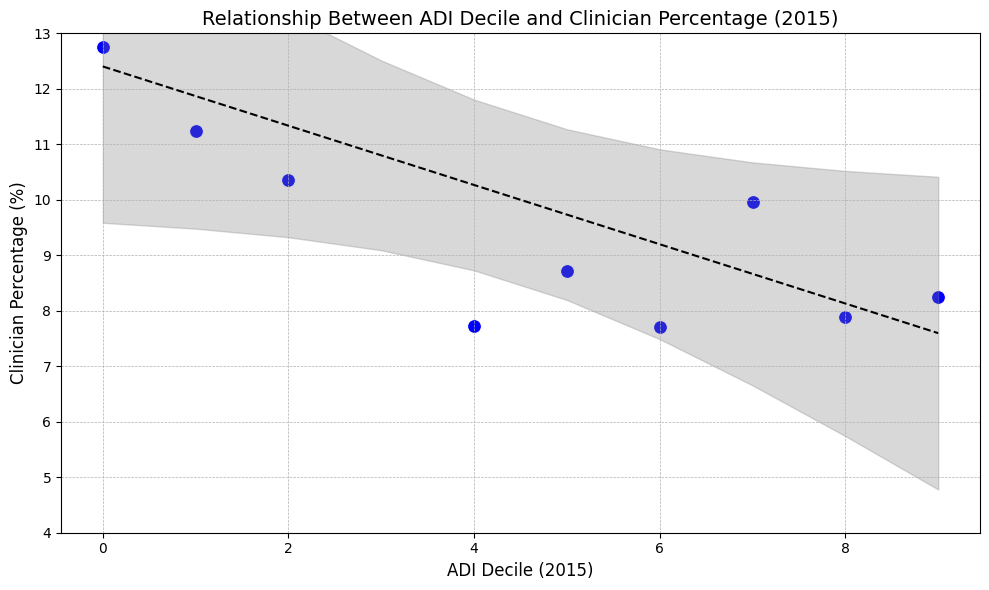

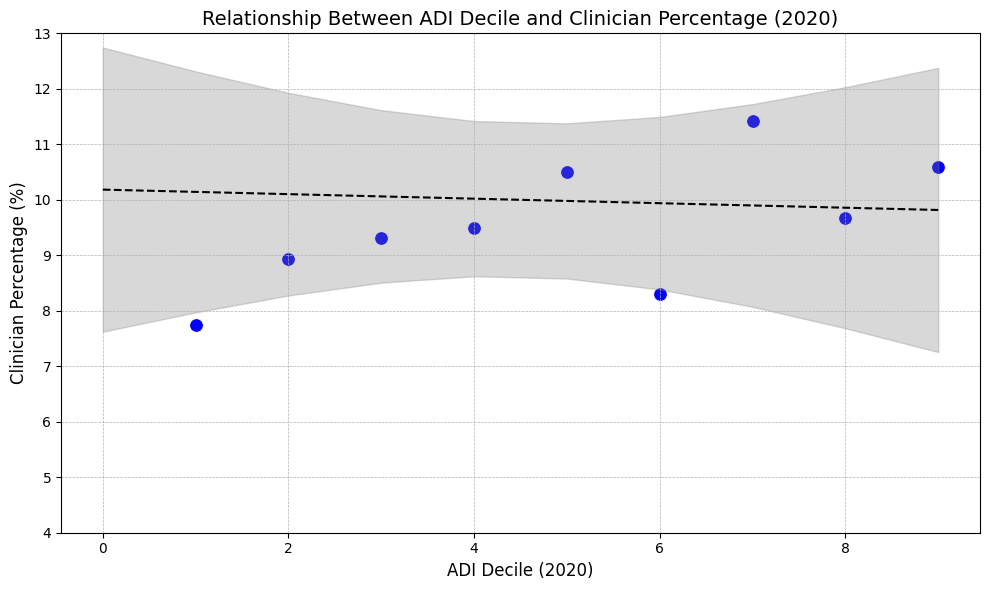

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Load the updated dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Function to select doctors based on top 20 institution flag
def select_doctors(data, top20_flag):
    return data[data['top20_institution'] == top20_flag]

# Function to prepare data: Summing Clinician Counts Across ADI Deciles
def prepare_aggregated_data(medical_data_top20):
    # Assign ADI Scores to Clinicians and aggregate data by ZIP Code and State
    adi_data_top20 = medical_data_top20[['ZIP Code', 'Grd_yr', 'State', 'Avg_ADI_NATRANK_2015', 'Avg_ADI_NATRANK_2020', 'top20_institution', 'pri_spec_grouped']]
    adi_data_top20['clinician_count'] = 1

    # Aggregate data by ZIP Code, Year, State, and ADI
    adi_aggregated_top20 = adi_data_top20.groupby(['ZIP Code', 'Grd_yr', 'State']).agg(
        total_clinicians=('clinician_count', 'sum'),
        Avg_ADI_2015=('Avg_ADI_NATRANK_2015', 'mean'),
        Avg_ADI_2020=('Avg_ADI_NATRANK_2020', 'mean')
    ).reset_index()

    # Group ADI Scores into Deciles
    adi_aggregated_top20['ADI_decile_2015'] = pd.qcut(adi_aggregated_top20['Avg_ADI_2015'], 10, labels=False)
    adi_aggregated_top20['ADI_decile_2020'] = pd.qcut(adi_aggregated_top20['Avg_ADI_2020'], 10, labels=False)

    return adi_aggregated_top20

# Function to aggregate clinician percentages
def calculate_clinician_percentage(adi_aggregated_top20, year):
    # Filter for the year (2015 or 2020)
    if year == 2015:
        decile_column = 'ADI_decile_2015'
    else:
        decile_column = 'ADI_decile_2020'

    adi_decile_density = adi_aggregated_top20[adi_aggregated_top20['Grd_yr'] == year].groupby(decile_column).agg(
        clinician_count=('total_clinicians', 'sum')
    ).reset_index()

    # Rename decile column to 'ADI_decile' for consistent access
    adi_decile_density.rename(columns={decile_column: 'ADI_decile'}, inplace=True)

    # Total clinicians for normalization
    total_clinicians = adi_decile_density['clinician_count'].sum()
    adi_decile_density['clinician_percentage'] = (adi_decile_density['clinician_count'] / total_clinicians) * 100

    return adi_decile_density


# Function to plot scatter plot with regression line and CI
def plot_scatter_with_regression(data, x_column, y_column, title, x_label, y_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=x_column, y=y_column, data=data, s=100, color='blue')

    # Fit a regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()
    y_pred = model.predict(X)

    # Plot regression line
    plt.plot(data[x_column], y_pred, color='black', linestyle='--', label='Regression Line')

    # Plot confidence interval
    pred = model.get_prediction(X)
    pred_ci = pred.conf_int()
    plt.fill_between(data[x_column], pred_ci[:, 0], pred_ci[:, 1], color='gray', alpha=0.3, label='95% Confidence Interval')

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.ylim(4, 13)

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

# Function to calculate regression statistics with proper access to confidence intervals
def calculate_regression_stats(data, x_column, y_column):
    # Fit the regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()

    # Extract regression statistics
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()  # Get the confidence interval

    return slope, intercept, r_squared, conf_int

# Main Function to Run the Analysis
def run_analysis(top20_flag):
    # Step 1: Select doctors based on the top 20 flag (1 for top 20 institutions, 0 for others)
    medical_data_selected = select_doctors(medical_data, top20_flag)

    # Step 2: Prepare aggregated data by summing clinician counts across deciles
    adi_aggregated_top20 = prepare_aggregated_data(medical_data_selected)

    # Step 3: Calculate clinician percentage for 2015 and 2020
    adi_decile_density_2015 = calculate_clinician_percentage(adi_aggregated_top20, 2015)
    adi_decile_density_2020 = calculate_clinician_percentage(adi_aggregated_top20, 2020)

    # Step 4: Calculate regression stats for 2015 and 2020
    slope_2015, intercept_2015, r_squared_2015, conf_int_2015 = calculate_regression_stats(adi_decile_density_2015, 'ADI_decile', 'clinician_percentage')
    slope_2020, intercept_2020, r_squared_2020, conf_int_2020 = calculate_regression_stats(adi_decile_density_2020, 'ADI_decile', 'clinician_percentage')

    # Print regression statistics for 2015
    print(f"2015 Regression Statistics:")
    print(f"Slope: {slope_2015:.4f}")
    print(f"Intercept: {intercept_2015:.4f}")
    print(f"R-squared: {r_squared_2015:.4f}")
    # Corrected access to the confidence interval using .iloc
    print(f"95% CI for Slope: ({conf_int_2015.iloc[1, 0]:.4f}, {conf_int_2015.iloc[1, 1]:.4f})\n")

    # Print regression statistics for 2020
    print(f"2020 Regression Statistics:")
    print(f"Slope: {slope_2020:.4f}")
    print(f"Intercept: {intercept_2020:.4f}")
    print(f"R-squared: {r_squared_2020:.4f}")
    print(f"95% CI for Slope: ({conf_int_2020.iloc[1, 0]:.4f}, {conf_int_2020.iloc[1, 1]:.4f})\n")

    # Step 5: Plot scatter plot with regression line for 2015
    plot_scatter_with_regression(
        adi_decile_density_2015,
        'ADI_decile',
        'clinician_percentage',
        'Relationship Between ADI Decile and Clinician Percentage (2015)',
        'ADI Decile (2015)',
        'Clinician Percentage (%)'
    )

    # Step 6: Plot scatter plot with regression line for 2020
    plot_scatter_with_regression(
        adi_decile_density_2020,
        'ADI_decile',
        'clinician_percentage',
        'Relationship Between ADI Decile and Clinician Percentage (2020)',
        'ADI Decile (2020)',
        'Clinician Percentage (%)'
    )

# Example of running the analysis for doctors from top 20 institutions
run_analysis(top20_flag=1)

# Example of running the analysis for doctors outside top 20 institutions
# run_analysis(top20_flag=0)


# Example of running the analysis for doctors outside top 20 institutions
# run_analysis(top20_flag=0)



v2

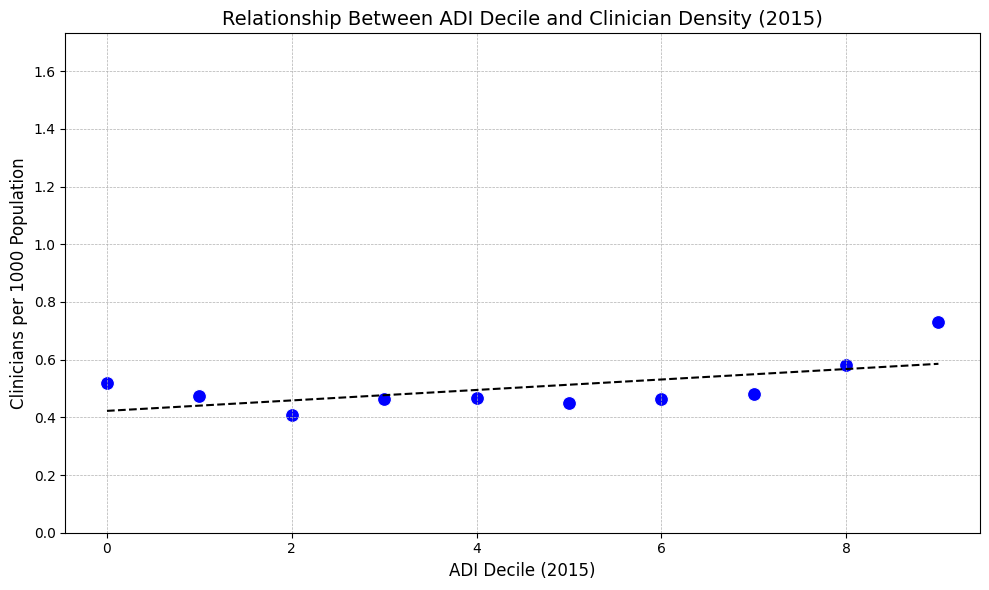

Relationship Between ADI Decile and Clinician Density (2015) Regression Statistics:
Slope: 0.0181
Intercept: 0.4224
R-squared: 0.3577
95% CI for Slope: (-0.0017, 0.0379)
95% CI for Intercept: (0.3167, 0.5281)



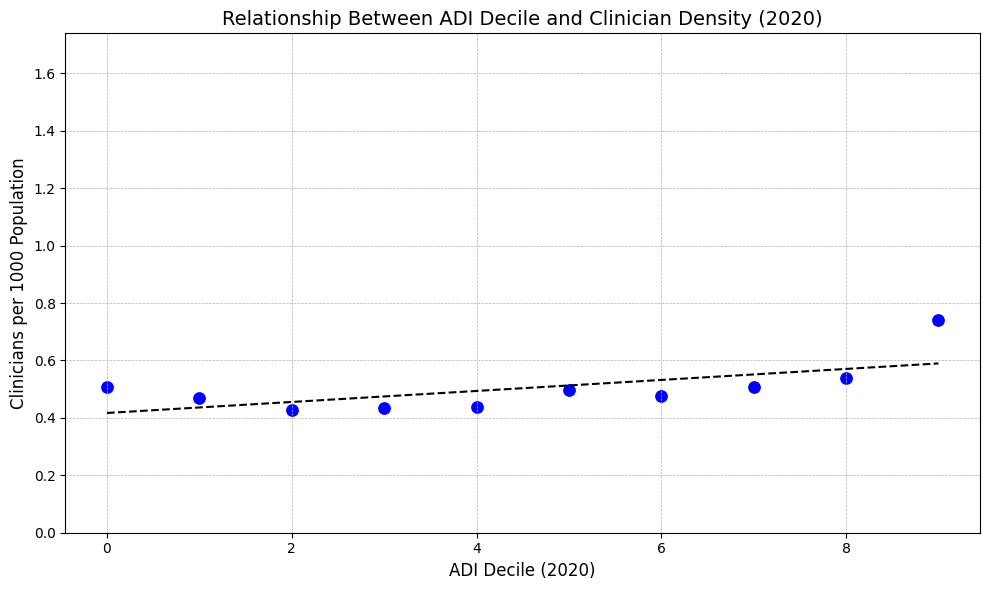

Relationship Between ADI Decile and Clinician Density (2020) Regression Statistics:
Slope: 0.0192
Intercept: 0.4171
R-squared: 0.4116
95% CI for Slope: (0.0005, 0.0379)
95% CI for Intercept: (0.3173, 0.5169)



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Load the updated dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Function to filter doctors based on top 20 flag
def filter_doctors(data, top20_flag):
    return data[data['top20_institution'] == top20_flag]

# Function to perform aggregation and prepare ADI decile data
def prepare_aggregated_data(data):
    # Assign ADI Scores to Clinicians and aggregate data by ZIP Code and State
    adi_data = data[['ZIP Code', 'Grd_yr', 'State', 'Avg_ADI_NATRANK_2015', 'Avg_ADI_NATRANK_2020',
                     'top20_institution', 'pri_spec_grouped', 'Estimate!!SEX AND AGE!!Total population']]
    adi_data['clinician_count'] = 1

    # Aggregate data by ZIP Code, Year, State, and ADI
    adi_aggregated = adi_data.groupby(['ZIP Code', 'Grd_yr', 'State']).agg(
        total_clinicians=('clinician_count', 'sum'),
        total_population=('Estimate!!SEX AND AGE!!Total population', 'mean'),  # Use mean to avoid double-counting population
        Avg_ADI_2015=('Avg_ADI_NATRANK_2015', 'mean'),
        Avg_ADI_2020=('Avg_ADI_NATRANK_2020', 'mean')
    ).reset_index()

    # Group ADI Scores into Deciles
    adi_aggregated['ADI_decile_2015'] = pd.qcut(adi_aggregated['Avg_ADI_2015'], 10, labels=False)
    adi_aggregated['ADI_decile_2020'] = pd.qcut(adi_aggregated['Avg_ADI_2020'], 10, labels=False)

    return adi_aggregated

# Function to calculate clinician density (clinicians per 1000 population) by ADI decile
def calculate_clinician_density(data, year):
    if year == 2015:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2015').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) #* 1000
        adi_decile_density.rename(columns={'ADI_decile_2015': 'ADI_decile'}, inplace=True)

    elif year == 2020:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2020').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) #* 1000
        adi_decile_density.rename(columns={'ADI_decile_2020': 'ADI_decile'}, inplace=True)

    return adi_decile_density

# Function to calculate regression statistics
def calculate_regression_stats(data, x_column, y_column):
    # Fit the regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()

    # Extract regression statistics
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    return slope, intercept, r_squared, conf_int

# Function to plot scatter plot with regression line and print regression stats (no confidence interval)
def plot_scatter_with_regression_and_stats_no_ci(data, x_column, y_column, title, x_label, y_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=x_column, y=y_column, data=data, s=100, color='blue')

    # Fit a regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()
    y_pred = model.predict(X)

    # Plot regression line
    plt.plot(data[x_column], y_pred, color='black', linestyle='--')

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.ylim(0, data[y_column].max() + 1)

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

    # Print regression stats
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    print(f"{title} Regression Statistics:")
    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"95% CI for Slope: ({conf_int.iloc[1, 0]:.4f}, {conf_int.iloc[1, 1]:.4f})")
    print(f"95% CI for Intercept: ({conf_int.iloc[0, 0]:.4f}, {conf_int.iloc[0, 1]:.4f})\n")

# Main function to run the analysis
def run_analysis_density_no_ci(top20_flag):
    # Step 1: Filter doctors based on top 20 flag (1 for top 20 institutions, 0 for others)
    medical_data_filtered = filter_doctors(medical_data, top20_flag)

    # Step 2: Prepare aggregated data with clinicians per 1000 population
    adi_aggregated = prepare_aggregated_data(medical_data_filtered)

    # Step 3: Calculate clinician density for 2015 and 2020
    adi_decile_density_2015 = calculate_clinician_density(adi_aggregated, 2015)
    adi_decile_density_2020 = calculate_clinician_density(adi_aggregated, 2020)

    # Step 4: Plot scatter plot with regression line for 2015
    plot_scatter_with_regression_and_stats_no_ci(
        adi_decile_density_2015,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2015)',
        'ADI Decile (2015)',
        'Clinicians per 1000 Population'
    )

    # Step 5: Plot scatter plot with regression line for 2020
    plot_scatter_with_regression_and_stats_no_ci(
        adi_decile_density_2020,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2020)',
        'ADI Decile (2020)',
        'Clinicians per 1000 Population'
    )

# Example of running the analysis for doctors from top 20 institutions
run_analysis_density_no_ci(top20_flag=0)


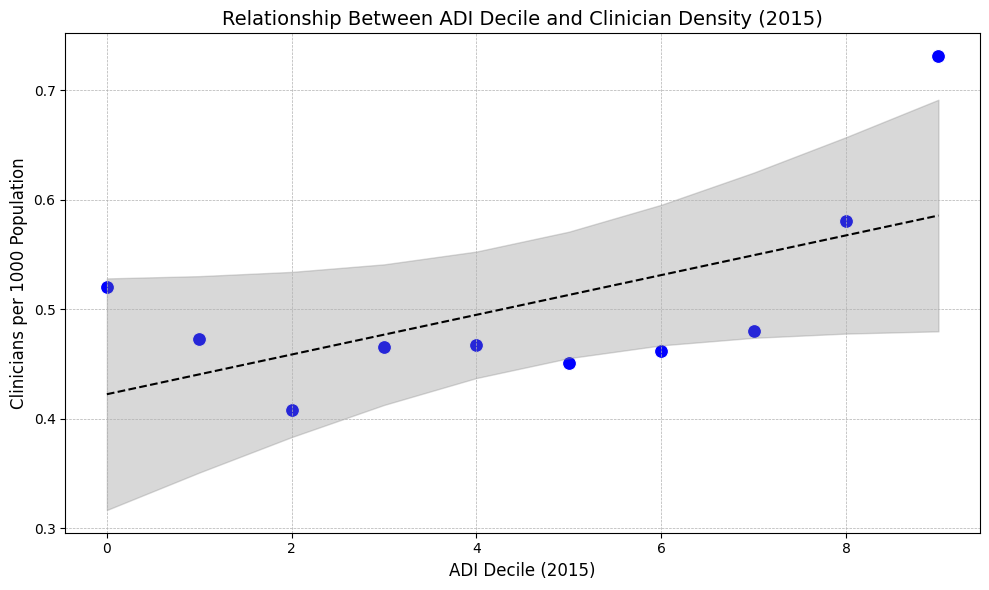

Slope: 0.0181
Intercept: 0.4224
R-squared: 0.3577
95% CI for Slope: (-0.0017, 0.0379)
95% CI for Intercept: (0.3167, 0.5281)



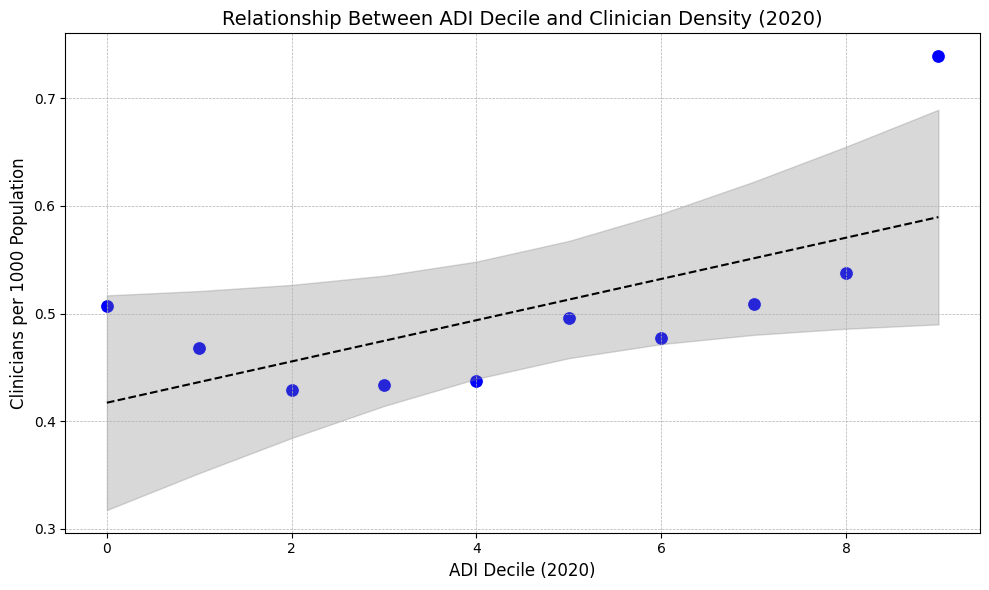

Slope: 0.0192
Intercept: 0.4171
R-squared: 0.4116
95% CI for Slope: (0.0005, 0.0379)
95% CI for Intercept: (0.3173, 0.5169)



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Load the updated dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Function to filter doctors based on top 20 flag
def filter_doctors(data, top20_flag):
    return data[data['top20_institution'] == top20_flag]

# Function to perform aggregation and prepare ADI decile data
def prepare_aggregated_data(data):
    # Assign ADI Scores to Clinicians and aggregate data by ZIP Code and State
    adi_data = data[['ZIP Code', 'Grd_yr', 'State', 'Avg_ADI_NATRANK_2015', 'Avg_ADI_NATRANK_2020',
                     'top20_institution', 'pri_spec_grouped', 'Estimate!!SEX AND AGE!!Total population']]
    adi_data['clinician_count'] = 1

    # Aggregate data by ZIP Code, Year, State, and ADI
    adi_aggregated = adi_data.groupby(['ZIP Code', 'Grd_yr', 'State']).agg(
        total_clinicians=('clinician_count', 'sum'),
        total_population=('Estimate!!SEX AND AGE!!Total population', 'mean'),  # Use mean to avoid double-counting population
        Avg_ADI_2015=('Avg_ADI_NATRANK_2015', 'mean'),
        Avg_ADI_2020=('Avg_ADI_NATRANK_2020', 'mean')
    ).reset_index()

    # Group ADI Scores into Deciles
    adi_aggregated['ADI_decile_2015'] = pd.qcut(adi_aggregated['Avg_ADI_2015'], 10, labels=False)
    adi_aggregated['ADI_decile_2020'] = pd.qcut(adi_aggregated['Avg_ADI_2020'], 10, labels=False)

    return adi_aggregated

# Function to calculate clinician density (clinicians per 1000 population) by ADI decile
def calculate_clinician_density(data, year):
    if year == 2015:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2015').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) #* 1000
        adi_decile_density.rename(columns={'ADI_decile_2015': 'ADI_decile'}, inplace=True)

    elif year == 2020:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2020').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) #* 1000
        adi_decile_density.rename(columns={'ADI_decile_2020': 'ADI_decile'}, inplace=True)

    return adi_decile_density

# Function to calculate regression statistics
def calculate_regression_stats(data, x_column, y_column):
    # Fit the regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()

    # Extract regression statistics
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    return slope, intercept, r_squared, conf_int

# Function to plot scatter plot with regression line, 95% CI, and print regression stats
def plot_scatter_with_regression_and_ci(data, x_column, y_column, title, x_label, y_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=x_column, y=y_column, data=data, s=100, color='blue')

    # Fit a regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()
    y_pred = model.predict(X)

    # Plot regression line
    plt.plot(data[x_column], y_pred, color='black', linestyle='--')

    # Plot 95% confidence interval
    pred = model.get_prediction(X)
    pred_ci = pred.conf_int()
    plt.fill_between(data[x_column], pred_ci[:, 0], pred_ci[:, 1], color='gray', alpha=0.3)

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    #plt.ylim(0, 1)

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

    # Print regression stats in specified format
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"95% CI for Slope: ({conf_int.iloc[1, 0]:.4f}, {conf_int.iloc[1, 1]:.4f})")
    print(f"95% CI for Intercept: ({conf_int.iloc[0, 0]:.4f}, {conf_int.iloc[0, 1]:.4f})\n")

# Main function to run the analysis
def run_analysis_with_ci(top20_flag):
    # Step 1: Filter doctors based on top 20 flag (1 for top 20 institutions, 0 for others)
    medical_data_filtered = filter_doctors(medical_data, top20_flag)

    # Step 2: Prepare aggregated data with clinicians per 1000 population
    adi_aggregated = prepare_aggregated_data(medical_data_filtered)

    # Step 3: Calculate clinician density for 2015 and 2020
    adi_decile_density_2015 = calculate_clinician_density(adi_aggregated, 2015)
    adi_decile_density_2020 = calculate_clinician_density(adi_aggregated, 2020)

    # Step 4: Plot scatter plot with regression line and 95% CI for 2015
    plot_scatter_with_regression_and_ci(
        adi_decile_density_2015,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2015)',
        'ADI Decile (2015)',
        'Clinicians per 1000 Population'
    )

    # Step 5: Plot scatter plot with regression line and 95% CI for 2020
    plot_scatter_with_regression_and_ci(
        adi_decile_density_2020,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2020)',
        'ADI Decile (2020)',
        'Clinicians per 1000 Population'
    )

# Example of running the analysis with the top20_flag
run_analysis_with_ci(top20_flag=0)




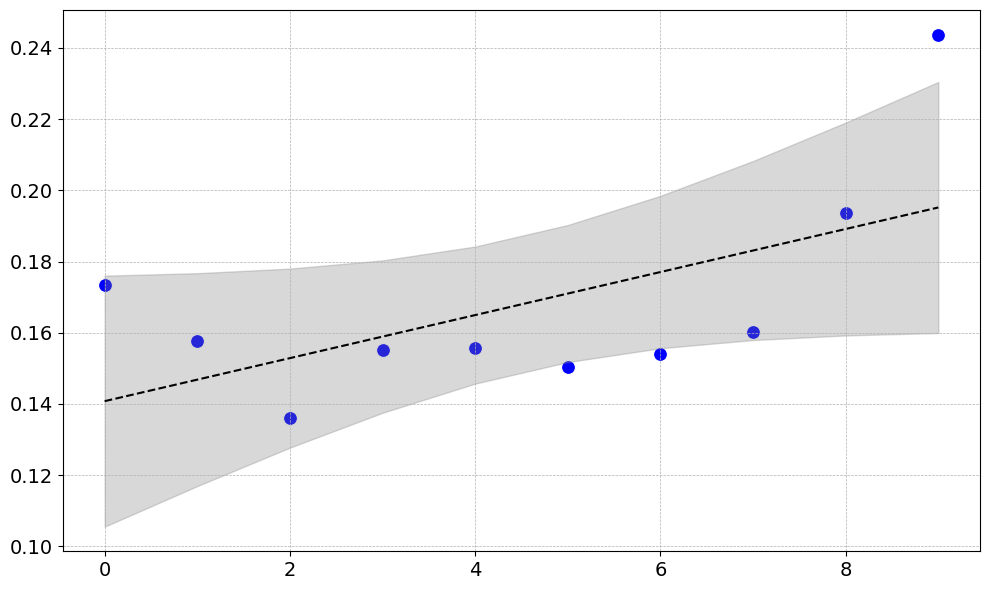

Slope: 0.0060
Intercept: 0.1408
R-squared: 0.3577
95% CI for Slope: (-0.0006, 0.0126)
95% CI for Intercept: (0.1056, 0.1760)



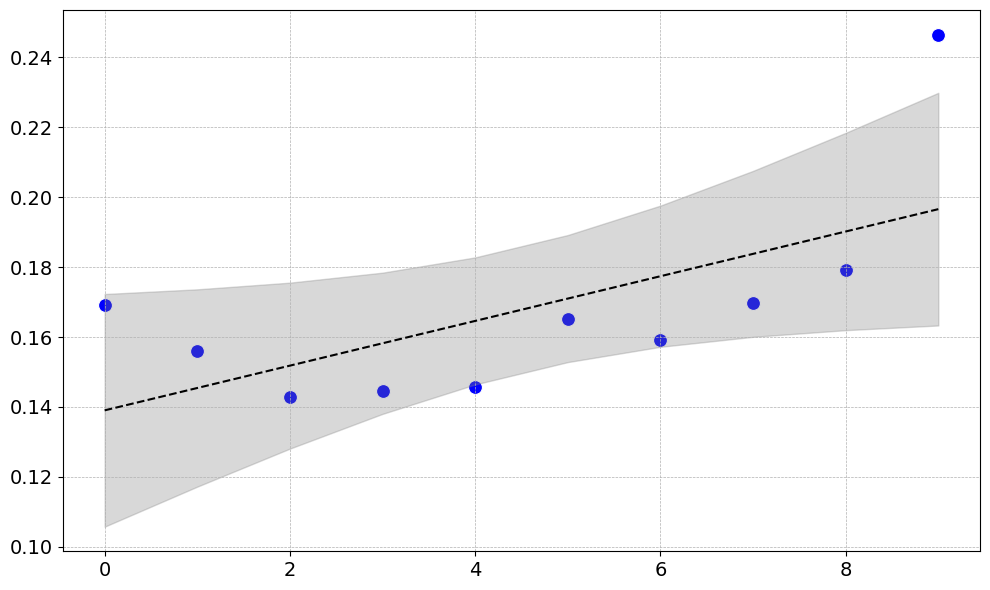

Slope: 0.0064
Intercept: 0.1390
R-squared: 0.4116
95% CI for Slope: (0.0002, 0.0126)
95% CI for Intercept: (0.1058, 0.1723)



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Load the updated dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Function to filter doctors based on top 20 flag
def filter_doctors(data, top20_flag):
    return data[data['top20_institution'] == top20_flag]

# Function to perform aggregation and prepare ADI decile data
def prepare_aggregated_data(data):
    # Assign ADI Scores to Clinicians and aggregate data by ZIP Code and State
    adi_data = data[['ZIP Code', 'Grd_yr', 'State', 'Avg_ADI_NATRANK_2015', 'Avg_ADI_NATRANK_2020',
                     'top20_institution', 'pri_spec_grouped', 'Estimate!!SEX AND AGE!!Total population']]
    adi_data['clinician_count'] = 1

    # Aggregate data by ZIP Code, Year, State, and ADI
    adi_aggregated = adi_data.groupby(['ZIP Code', 'Grd_yr', 'State']).agg(
        total_clinicians=('clinician_count', 'sum'),
        total_population=('Estimate!!SEX AND AGE!!Total population', 'mean'),  # Use mean to avoid double-counting population
        Avg_ADI_2015=('Avg_ADI_NATRANK_2015', 'mean'),
        Avg_ADI_2020=('Avg_ADI_NATRANK_2020', 'mean')
    ).reset_index()

    # Group ADI Scores into Deciles
    adi_aggregated['ADI_decile_2015'] = pd.qcut(adi_aggregated['Avg_ADI_2015'], 10, labels=False)
    adi_aggregated['ADI_decile_2020'] = pd.qcut(adi_aggregated['Avg_ADI_2020'], 10, labels=False)

    return adi_aggregated

# Function to calculate clinician density (clinicians per 1000 population) by ADI decile
def calculate_clinician_density(data, year):
    if year == 2015:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2015').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) / 3
        adi_decile_density.rename(columns={'ADI_decile_2015': 'ADI_decile'}, inplace=True)

    elif year == 2020:
        # Aggregate by ADI decile, taking the sum of clinicians and the mean population per decile
        adi_decile_density = data.groupby('ADI_decile_2020').agg(
            clinician_count=('total_clinicians', 'sum'),
            avg_population=('total_population', 'mean')
        ).reset_index()

        # Calculate clinicians per 1000 population based on the average population
        adi_decile_density['clinician_density'] = (adi_decile_density['clinician_count'] / adi_decile_density['avg_population']) / 3
        adi_decile_density.rename(columns={'ADI_decile_2020': 'ADI_decile'}, inplace=True)

    return adi_decile_density

# Function to calculate regression statistics
def calculate_regression_stats(data, x_column, y_column):
    # Fit the regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()

    # Extract regression statistics
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    return slope, intercept, r_squared, conf_int

# Function to plot scatter plot with regression line, 95% CI, and print regression stats
def plot_scatter_with_regression_and_ci(data, x_column, y_column, title, x_label, y_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=x_column, y=y_column, data=data, s=100, color='blue')

    # Fit a regression model
    X = sm.add_constant(data[x_column])
    model = sm.OLS(data[y_column], X).fit()
    y_pred = model.predict(X)

    # Plot regression line
    plt.plot(data[x_column], y_pred, color='black', linestyle='--')

    # Plot 95% confidence interval
    pred = model.get_prediction(X)
    pred_ci = pred.conf_int()
    plt.fill_between(data[x_column], pred_ci[:, 0], pred_ci[:, 1], color='gray', alpha=0.3)

    # Add labels and title
    plt.title('', fontsize=14)
    plt.xlabel('', fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.xticks(fontsize=14)  # Increase x-axis tick font size
    plt.yticks(fontsize=14)  # Increase y-axis tick font size
    #plt.ylim(0, 1)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

    # Print regression stats in specified format
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    conf_int = model.conf_int()

    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"95% CI for Slope: ({conf_int.iloc[1, 0]:.4f}, {conf_int.iloc[1, 1]:.4f})")
    print(f"95% CI for Intercept: ({conf_int.iloc[0, 0]:.4f}, {conf_int.iloc[0, 1]:.4f})\n")

# Main function to run the analysis
def run_analysis_with_ci(top20_flag):
    # Step 1: Filter doctors based on top 20 flag (1 for top 20 institutions, 0 for others)
    medical_data_filtered = filter_doctors(medical_data, top20_flag)

    # Step 2: Prepare aggregated data with clinicians per 1000 population
    adi_aggregated = prepare_aggregated_data(medical_data_filtered)

    # Step 3: Calculate clinician density for 2015 and 2020
    adi_decile_density_2015 = calculate_clinician_density(adi_aggregated, 2015)
    adi_decile_density_2020 = calculate_clinician_density(adi_aggregated, 2020)

    # Step 4: Plot scatter plot with regression line and 95% CI for 2015
    plot_scatter_with_regression_and_ci(
        adi_decile_density_2015,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2015)',
        'ADI Decile (2015)',
        'Clinicians per 1000 Population'
    )

    # Step 5: Plot scatter plot with regression line and 95% CI for 2020
    plot_scatter_with_regression_and_ci(
        adi_decile_density_2020,
        'ADI_decile',
        'clinician_density',
        'Relationship Between ADI Decile and Clinician Density (2020)',
        'ADI Decile (2020)',
        'Clinicians per 1000 Population'
    )

# Example of running the analysis with the top20_flag
run_analysis_with_ci(top20_flag=0)




Forest plots


Processing group: 2015 Top20
Number of observations in '2015 Top20': 3283
Distribution of 'High_ADI_Placement':
High_ADI_Placement
0    2957
1     326
Name: count, dtype: int64

Processing group: 2015 Non-Top20
Number of observations in '2015 Non-Top20': 80550
Distribution of 'High_ADI_Placement':
High_ADI_Placement
0    64103
1    16447
Name: count, dtype: int64

Processing group: 2020 Top20
Number of observations in '2020 Top20': 1085
Distribution of 'High_ADI_Placement':
High_ADI_Placement
0    967
1    118
Name: count, dtype: int64

Processing group: 2020 Non-Top20
Number of observations in '2020 Non-Top20': 69205
Distribution of 'High_ADI_Placement':
High_ADI_Placement
0    55258
1    13947
Name: count, dtype: int64


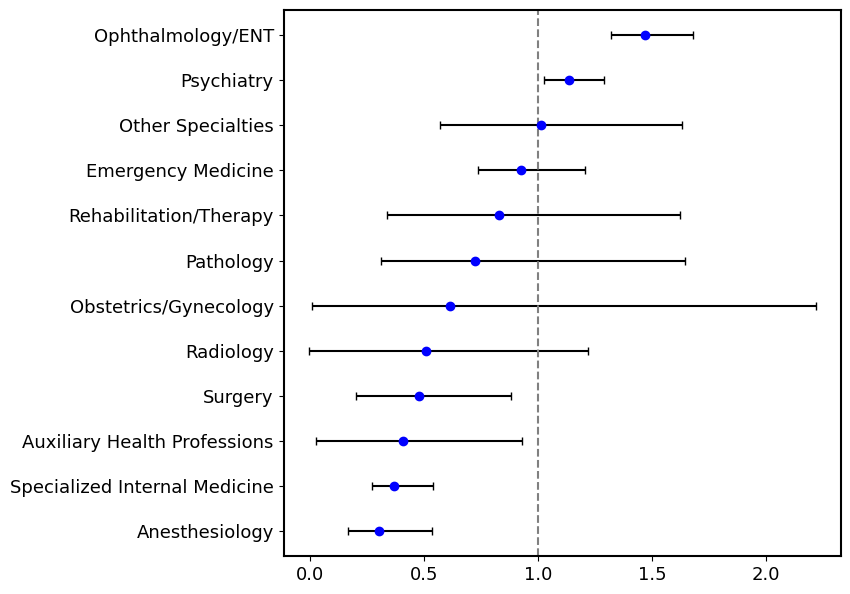

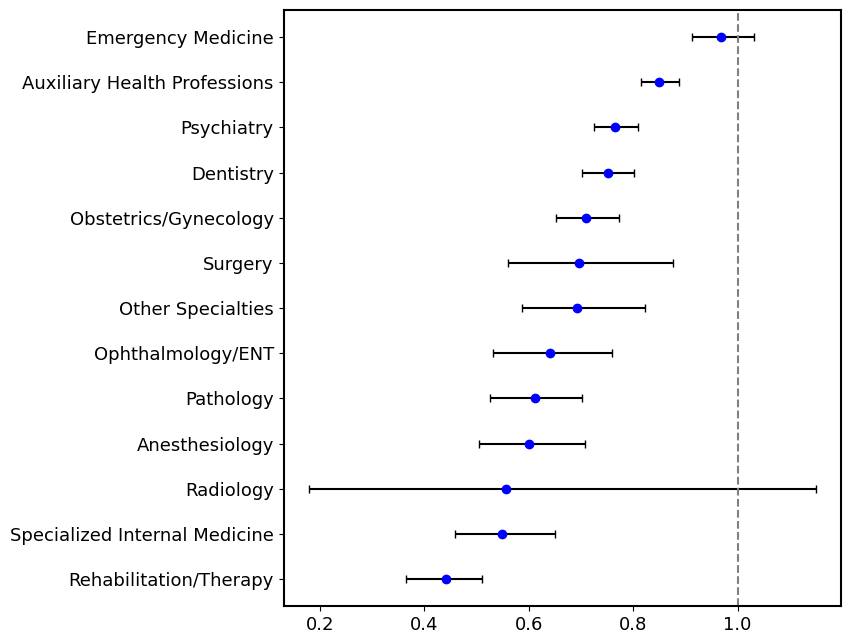

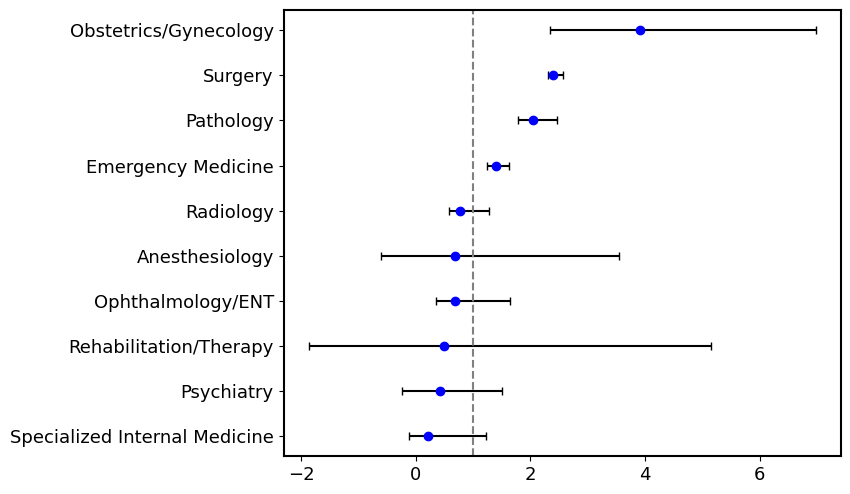

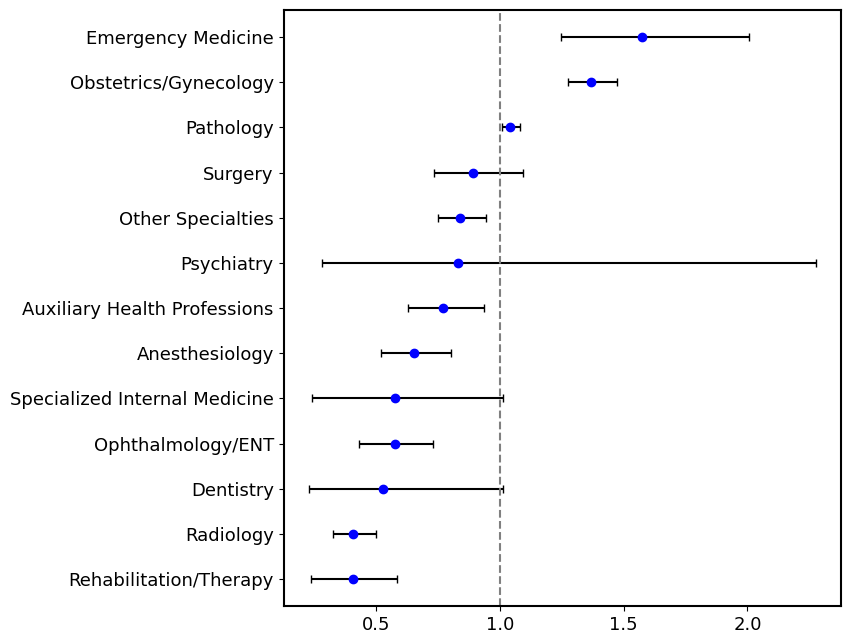

Regression results saved to 'regression_results_for_stata.csv'


In [ ]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 2: Load dataset
file_path = '/content/cleaned_medical_population_data.csv'  # Update with your actual file path
medical_data = pd.read_csv(file_path)

# Step 3: Data Preprocessing

# Convert 'Grd_yr' to integer
medical_data['Grd_yr'] = medical_data['Grd_yr'].astype(int)

# Handle missing values by dropping rows with missing data in key columns
medical_data = medical_data.dropna(subset=[
    'gndr', 'Med_sch', 'pri_spec', 'Avg_ADI_NATRANK_2015',
    'Avg_ADI_NATRANK_2020', 'Estimate!!SEX AND AGE!!Total population'
])

# Step 3a: Ensure Data Includes Only First Job Placements

# For 2015 cohort: Include 2014 and 2015 graduates
cohort_2015 = medical_data[medical_data['Grd_yr'].isin([2014, 2015])].copy()

# For 2020 cohort: Include 2019 and 2020 graduates
cohort_2020 = medical_data[medical_data['Grd_yr'].isin([2019, 2020])].copy()

# Step 4: Create Low_ADI_Placement and High_ADI_Placement Variables

# For 2015 cohort
adi_threshold_low_2015 = cohort_2015['Avg_ADI_NATRANK_2015'].quantile(0.2)
adi_threshold_high_2015 = cohort_2015['Avg_ADI_NATRANK_2015'].quantile(0.8)
cohort_2015['Low_ADI_Placement'] = (cohort_2015['Avg_ADI_NATRANK_2015'] <= adi_threshold_low_2015).astype(int)
cohort_2015['High_ADI_Placement'] = (cohort_2015['Avg_ADI_NATRANK_2015'] >= adi_threshold_high_2015).astype(int)

# For 2020 cohort
adi_threshold_low_2020 = cohort_2020['Avg_ADI_NATRANK_2020'].quantile(0.2)
adi_threshold_high_2020 = cohort_2020['Avg_ADI_NATRANK_2020'].quantile(0.8)
cohort_2020['Low_ADI_Placement'] = (cohort_2020['Avg_ADI_NATRANK_2020'] <= adi_threshold_low_2020).astype(int)
cohort_2020['High_ADI_Placement'] = (cohort_2020['Avg_ADI_NATRANK_2020'] >= adi_threshold_high_2020).astype(int)

# Step 5: Group Primary Specializations

# Define the mapping dictionary for grouping primary specializations
specialty_group_mapping = {
    # Primary Care
    'FAMILY PRACTICE': 'Primary Care',
    'GENERAL PRACTICE': 'Primary Care',
    'INTERNAL MEDICINE': 'Primary Care',
    'PEDIATRIC MEDICINE': 'Primary Care',
    'GERIATRIC MEDICINE': 'Primary Care',

    # Surgery
    'GENERAL SURGERY': 'Surgery',
    'ORTHOPEDIC SURGERY': 'Surgery',
    'NEUROSURGERY': 'Surgery',
    'CARDIAC SURGERY': 'Surgery',
    'VASCULAR SURGERY': 'Surgery',
    'THORACIC SURGERY': 'Surgery',
    'PLASTIC AND RECONSTRUCTIVE SURGERY': 'Surgery',
    'COLORECTAL SURGERY (PROCTOLOGY)': 'Surgery',
    'HAND SURGERY': 'Surgery',
    'MAXILLOFACIAL SURGERY': 'Surgery',
    'SURGICAL ONCOLOGY': 'Surgery',
    'UROLOGY': 'Surgery',
    'OTOLARYNGOLOGY': 'Surgery',

    # Specialized Internal Medicine
    'CARDIOVASCULAR DISEASE (CARDIOLOGY)': 'Specialized Internal Medicine',
    'ENDOCRINOLOGY': 'Specialized Internal Medicine',
    'GASTROENTEROLOGY': 'Specialized Internal Medicine',
    'INFECTIOUS DISEASE': 'Specialized Internal Medicine',
    'NEPHROLOGY': 'Specialized Internal Medicine',
    'PULMONARY DISEASE': 'Specialized Internal Medicine',
    'RHEUMATOLOGY': 'Specialized Internal Medicine',
    'HEMATOLOGY': 'Specialized Internal Medicine',
    'HEMATOLOGY/ONCOLOGY': 'Specialized Internal Medicine',
    'MEDICAL ONCOLOGY': 'Specialized Internal Medicine',
    'NEUROLOGY': 'Specialized Internal Medicine',
    'DERMATOLOGY': 'Specialized Internal Medicine',
    'ALLERGY/IMMUNOLOGY': 'Specialized Internal Medicine',
    'HOSPITALIST': 'Specialized Internal Medicine',
    'CRITICAL CARE (INTENSIVISTS)': 'Specialized Internal Medicine',
    'SLEEP MEDICINE': 'Specialized Internal Medicine',
    'PAIN MANAGEMENT': 'Specialized Internal Medicine',
    'SPORTS MEDICINE': 'Specialized Internal Medicine',
    'CARDIAC ELECTROPHYSIOLOGY': 'Specialized Internal Medicine',
    'INTERVENTIONAL CARDIOLOGY': 'Specialized Internal Medicine',
    'ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY': 'Specialized Internal Medicine',
    'PERIPHERAL VASCULAR DISEASE': 'Specialized Internal Medicine',
    'MEDICAL GENETICS AND GENOMICS': 'Specialized Internal Medicine',
    'UNDERSEA AND HYPERBARIC MEDICINE': 'Specialized Internal Medicine',
    'MEDICAL TOXICOLOGY': 'Specialized Internal Medicine',
    'INTERVENTIONAL PAIN MANAGEMENT': 'Specialized Internal Medicine',
    'ADULT CONGENITAL HEART DISEASE (ACHD)': 'Specialized Internal Medicine',
    'HEMATOPOIETIC CELL TRANSPLANTATION AND CELLULAR THERAPY': 'Specialized Internal Medicine',

    # Psychiatry
    'PSYCHIATRY': 'Psychiatry',
    'GERIATRIC PSYCHIATRY': 'Psychiatry',
    'NEUROPSYCHIATRY': 'Psychiatry',
    'ADDICTION MEDICINE': 'Psychiatry',
    'CLINICAL PSYCHOLOGIST': 'Psychiatry',
    'MENTAL HEALTH COUNSELOR': 'Psychiatry',
    'MARRIAGE AND FAMILY THERAPIST': 'Psychiatry',
    'CLINICAL SOCIAL WORKER': 'Psychiatry',

    # Emergency Medicine
    'EMERGENCY MEDICINE': 'Emergency Medicine',

    # Anesthesiology
    'ANESTHESIOLOGY': 'Anesthesiology',
    'ANESTHESIOLOGY ASSISTANT': 'Anesthesiology',

    # Radiology
    'DIAGNOSTIC RADIOLOGY': 'Radiology',
    'INTERVENTIONAL RADIOLOGY': 'Radiology',
    'NUCLEAR MEDICINE': 'Radiology',
    'RADIATION ONCOLOGY': 'Radiology',

    # Obstetrics/Gynecology
    'OBSTETRICS/GYNECOLOGY': 'Obstetrics/Gynecology',
    'GYNECOLOGICAL ONCOLOGY': 'Obstetrics/Gynecology',
    'CERTIFIED NURSE MIDWIFE (CNM)': 'Obstetrics/Gynecology',

    # Ophthalmology/ENT
    'OPHTHALMOLOGY': 'Ophthalmology/ENT',
    'QUALIFIED AUDIOLOGIST': 'Ophthalmology/ENT',

    # Rehabilitation/Therapy
    'PHYSICAL THERAPY': 'Rehabilitation/Therapy',
    'OCCUPATIONAL THERAPY': 'Rehabilitation/Therapy',
    'PHYSICAL MEDICINE AND REHABILITATION': 'Rehabilitation/Therapy',
    'QUALIFIED SPEECH LANGUAGE PATHOLOGIST': 'Rehabilitation/Therapy',

    # Pathology
    'PATHOLOGY': 'Pathology',

    # Advanced Practice Providers
    'NURSE PRACTITIONER': 'Advanced Practice Providers',
    'PHYSICIAN ASSISTANT': 'Advanced Practice Providers',
    'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)': 'Advanced Practice Providers',
    'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)': 'Advanced Practice Providers',

    # Dentistry
    'DENTIST': 'Dentistry',
    'ORAL SURGERY': 'Dentistry',
    'ORAL MEDICINE': 'Dentistry',
    'ORAL AND MAXILLOFACIAL RADIOLOGY': 'Dentistry',

    # Auxiliary Health Professions
    'OPTOMETRY': 'Auxiliary Health Professions',
    'REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL': 'Auxiliary Health Professions',
    'PODIATRY': 'Auxiliary Health Professions',
    'HOSPICE/PALLIATIVE CARE': 'Auxiliary Health Professions',
}


# Apply the mapping to 'pri_spec_grouped'
cohort_2015['pri_spec_grouped'] = cohort_2015['pri_spec'].map(specialty_group_mapping)
cohort_2020['pri_spec_grouped'] = cohort_2020['pri_spec'].map(specialty_group_mapping)

# Handle unmapped specializations by assigning 'Other Specialties'
cohort_2015['pri_spec_grouped'] = cohort_2015['pri_spec_grouped'].fillna('Other Specialties')
cohort_2020['pri_spec_grouped'] = cohort_2020['pri_spec_grouped'].fillna('Other Specialties')

# Step 6: Incorporate Top 20 Medical Schools

# List of top 20 medical schools
top_20_institutions = {
    "HARVARD MEDICAL SCHOOL": "MA",
    "JOHNS HOPKINS UNIVERSITY SCHOOL OF MEDICINE": "MD",
    "PERELMAN SCHOOL OF MED AT THE UNIVERSITY OF PENNSYLVANIA": "PA",
    "COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND SURGEONS": "NY",
    "DUKE UNIVERSITY SCHOOL OF MEDICINE": "NC",
    "STANFORD UNIVERSITY SCHOOL OF MEDICINE": "CA",
    "UNIVERSITY OF CALIFORNIA, SAN FRANCISCO SCHOOL OF MEDICINE": "CA",
    "VANDERBILT UNIVERSITY SCHOOL OF MEDICINE": "TN",
    "WASHINGTON UNIVERSITY SCHOOL OF MEDICINE": "MO",
    "JS WEILL MEDICAL COLLEGE, CORNELL UNIVERSITY": "NY",
    "NEW YORK UNIVERSITY SCHOOL OF MEDICINE": "NY",
    "YALE UNIVERSITY SCHOOL OF MEDICINE": "CT",
    "MAYO MEDICAL SCHOOL": "MN",
    "NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL": "IL",
    "UNIVERSITY OF MICHIGAN MEDICAL SCHOOL": "MI",
    "UNIVERSITY OF PITTSBURGH SCHOOL OF MEDICINE": "PA",
    "UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE": "WA",
    "ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI": "NY",
    "UNIVERSITY OF CALIFORNIA, GEFFEN SCHOOL OF MEDICINE": "CA",
    "UNIVERSITY OF CHICAGO, PRITZKER SCHOOL OF MEDICINE": "IL",
    "UNIVERSITY OF CALIFORNIA, SAN DIEGO SCHOOL OF MEDICINE": "CA"
}

# Create the set of top 20 medical schools
top_20_schools_set = set(top_20_institutions.keys())

# Clean 'Med_sch' to match the format of top 20 schools
cohort_2015['Med_sch_cleaned'] = cohort_2015['Med_sch'].str.upper().str.strip()
cohort_2020['Med_sch_cleaned'] = cohort_2020['Med_sch'].str.upper().str.strip()

# Create the 'top20_institution' flag
cohort_2015['top20_institution'] = cohort_2015['Med_sch_cleaned'].apply(
    lambda x: 1 if x in top_20_schools_set else 0)
cohort_2020['top20_institution'] = cohort_2020['Med_sch_cleaned'].apply(
    lambda x: 1 if x in top_20_schools_set else 0)

# Step 7: Prepare Data for Logistic Regression

# Clean and prepare the data
cohort_2015['gndr'] = cohort_2015['gndr'].str.upper().str.strip()
cohort_2020['gndr'] = cohort_2020['gndr'].str.upper().str.strip()
cohort_2015['pri_spec_grouped'] = cohort_2015['pri_spec_grouped'].str.strip()
cohort_2020['pri_spec_grouped'] = cohort_2020['pri_spec_grouped'].str.strip()

# Rename the population column to something simpler for easier reference
cohort_2015['Total_Population'] = cohort_2015['Estimate!!SEX AND AGE!!Total population']
cohort_2020['Total_Population'] = cohort_2020['Estimate!!SEX AND AGE!!Total population']

# Remove rows where Total_Population is zero or negative
cohort_2015 = cohort_2015[cohort_2015['Total_Population'] > 0].copy()
cohort_2020 = cohort_2020[cohort_2020['Total_Population'] > 0].copy()

# Apply log transformation
cohort_2015['Log_Total_Population'] = np.log(cohort_2015['Total_Population'])
cohort_2020['Log_Total_Population'] = np.log(cohort_2020['Total_Population'])

# Step 8: Split Data into Four Groups

# For 2015 cohort
cohort_2015_top20 = cohort_2015[cohort_2015['top20_institution'] == 1].copy()
cohort_2015_not_top20 = cohort_2015[cohort_2015['top20_institution'] == 0].copy()

# For 2020 cohort
cohort_2020_top20 = cohort_2020[cohort_2020['top20_institution'] == 1].copy()
cohort_2020_not_top20 = cohort_2020[cohort_2020['top20_institution'] == 0].copy()

# Combine into a dictionary for easier processing
groups = {
    '2015 Top20': cohort_2015_top20,
    '2015 Non-Top20': cohort_2015_not_top20,
    '2020 Top20': cohort_2020_top20,
    '2020 Non-Top20': cohort_2020_not_top20,
}

# Step 9: Fit Logistic Regression Models and Collect ORs

results = []

for group_name, data in groups.items():
    print(f"\nProcessing group: {group_name}")
    # Check sample size
    print(f"Number of observations in '{group_name}': {len(data)}")
    if len(data) < 50:
        print(f"Skipping {group_name} due to insufficient data.")
        continue
    # Check distribution of 'High_ADI_Placement'
    print("Distribution of 'High_ADI_Placement':")
    print(data['High_ADI_Placement'].value_counts())
    if data['High_ADI_Placement'].nunique() < 2:
        print(f"Skipping {group_name} due to lack of variation in High_ADI_Placement.")
        continue
    # Prepare data
    X = pd.get_dummies(data[['pri_spec_grouped', 'gndr']], drop_first=True)
    X['Log_Total_Population'] = data['Log_Total_Population']
    y = data['High_ADI_Placement']

    # Convert boolean columns to integers
    X = X.astype(int)

    # Ensure all data in X is numeric and handle missing values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().any().any():
        X.dropna(inplace=True)
        y = y.loc[X.index]
        print(f"Dropped rows with NaN or infinite values. New sample size: {len(X)}")

    # Fit logistic regression with L2 regularization
    model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    try:
        model.fit(X, y)
    except Exception as e:
        print(f"Could not fit model for group {group_name}: {e}")
        continue

    # Get coefficients and compute odds ratios
    coef = model.coef_[0]
    odds_ratios = np.exp(coef)
    # Get variable names
    variables = X.columns
    # Create a DataFrame for odds ratios
    odds_ratios_df = pd.DataFrame({
        'Group': group_name,
        'Variable': variables,
        'Coefficient': coef,
        'OR': odds_ratios
    })
    # Compute confidence intervals using bootstrapping
    boot_iterations = 1000
    boot_coefs = []
    for i in range(boot_iterations):
        # Resample the data
        X_resample, y_resample = resample(X, y)
        # Fit the model
        model.fit(X_resample, y_resample)
        # Store coefficients
        boot_coefs.append(model.coef_[0])
    boot_coefs = np.array(boot_coefs)
    # Compute 2.5% and 97.5% percentiles
    lower_bounds = np.exp(np.percentile(boot_coefs, 2.5, axis=0))
    upper_bounds = np.exp(np.percentile(boot_coefs, 97.5, axis=0))
    odds_ratios_df['2.5%'] = lower_bounds
    odds_ratios_df['97.5%'] = upper_bounds
    # Filter for 'pri_spec_grouped' variables
    spec_vars = [var for var in variables if var.startswith('pri_spec_grouped_')]
    odds_ratios_df = odds_ratios_df[odds_ratios_df['Variable'].isin(spec_vars)]
    # Extract specialization names
    odds_ratios_df['Specialization'] = odds_ratios_df['Variable'].str.replace('pri_spec_grouped_', '')
    # Exclude the reference category 'Primary Care' from the plot
    odds_ratios_df = odds_ratios_df[odds_ratios_df['Specialization'] != 'Primary Care']
    results.append(odds_ratios_df)

# Combine all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Step 10: Plot Forest Plots Based on Regression Results

# For each group, create a forest plot
for group_name in results_df['Group'].unique():
    data = results_df[results_df['Group'] == group_name]
    # Replace NaNs in '2.5%' and '97.5%' with OR (so errors will be zero)
    data['2.5%'] = data['2.5%'].fillna(data['OR'])
    data['97.5%'] = data['97.5%'].fillna(data['OR'])
    # Compute errors
    lower_errors = data['OR'] - data['2.5%']
    upper_errors = data['97.5%'] - data['OR']
    # Sort data by OR
    data = data.sort_values('OR')
    # Plotting
    fig, ax = plt.subplots(figsize=(8, len(data)*0.5))
    y_pos = np.arange(len(data))
    ax.errorbar(data['OR'], y_pos, xerr=[lower_errors, upper_errors], fmt='o', color='blue',
                ecolor='black', capsize=3)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data['Specialization'])
    ax.axvline(x=1, color='grey', linestyle='--')
    ax.set_xlabel('')
    ax.set_title(f'')

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness as desired

    plt.tight_layout()
    plt.xticks(fontsize=13)  # Increase x-axis tick font size
    plt.yticks(fontsize=13)  # Increase y-axis tick font size
    plt.show()

# Step 11: Save Regression Results for Stata

# Prepare the DataFrame for Stata
stata_results_df = results_df[['Group', 'Specialization', 'OR', '2.5%', '97.5%']].copy()
stata_results_df.columns = ['group', 'specialization', 'or', 'ci_lower', 'ci_upper']

# Export the results_df to a CSV file
stata_results_df.to_csv('regression_results_for_stata.csv', index=False)
print("Regression results saved to 'regression_results_for_stata.csv'")
